In [1]:
# Parameters
symbol = '^GSPC'
start_date = None # "1970"

In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize
from scipy.special import expit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

import seaborn as sns

from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

/home/chiao/miniconda3/lib/python3.10/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [4]:
data = yf.Ticker(symbol).history(period='max', auto_adjust=True)[start_date:]

In [5]:
data = data.query("High > Low")

In [6]:
# Note that when using ^GSPC, there are no dividends, and it's also 
# not really directly tradeable - I'll do a continuous futures version 
# at some point

# Rest of analysis assumes non-stock allocation is in cash, 
# but in reality you would have some gains from being in bonds as well

# We add transaction costs further down this sheet

sp_rets = data['Close'].transform(lambda xs: xs / xs.shift() - 1).rename('rets')

In [7]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

In [8]:
import lightgbm as lgb
import sympy as sp
from scipy import optimize

In [9]:
from sympy.abc import x, r

expr = -sp.log(1 + sp.Piecewise((0, x < 0), (1, x > 1), (x, True)) * r)
expr = sp.simplify(expr)
loss = sp.lambdify([r, x], expr, "numpy")
expr

Piecewise((0, x < 0), (-log(r + 1), x > 1), (-log(r*x + 1), True))

In [10]:
expr_grad = sp.simplify(expr.diff(x))
loss_grad = sp.lambdify([r, x], expr_grad, "numpy")
expr_grad

Piecewise((0, (x > 1) | (x < 0)), (-r/(r*x + 1), True))

In [11]:
expr_hess = sp.simplify(expr.diff(x, 2))
loss_hess = sp.lambdify([r, x], expr_hess, "numpy")
expr_hess

Piecewise((0, (x > 1) | (x < 0)), (r**2/(r*x + 1)**2, True))

In [12]:
def init_score(r):
    res = optimize.minimize_scalar(
        lambda x: loss(r, x).mean(),
        bounds=(-100, 100),
        method='bounded'
    )
    return res.x

In [13]:
def lgb_obj(x, ds):
    r = ds.get_label()
    return loss_grad(r, x), loss_hess(r, x)

In [14]:
def lgb_eval(x, ds):
    r = ds.get_label()
    is_higher_better = False
    return 'log_ret', loss(r, x).mean(), is_higher_better

In [15]:
windows = list(range(50, 201, 50))
print(windows)
feats = pd.concat([
    sp_rets.shift().cumsum()
    .transform(lambda xs: xs.rolling(i).mean().div(xs.rolling(j).mean()).rename(f"{i}/{j}"))
    for i in windows
    for j in [200]
    if i < j
], axis=1)

# feats["MA30"] = data.shift().eval("High - Low").rolling(30).mean()
# feats["ind"] = data.shift().eval("High - Low").div(
#     data.shift().eval("High - Low").rolling(30).mean()
# )
# feats = feats[["ind", "MA30"]]

print(feats.columns)

# target = sp_rets.iloc[::-1].rolling(30).mean().iloc[::-1] * 3
target = sp_rets * 3

mask = feats.notnull().all(axis=1) & target.notnull()

feats = feats[mask]
target = target[mask]

train_ix = feats.index < "2010"

score0 = 0.1

train_ds = lgb.Dataset(
    feats[train_ix].astype(float), target[train_ix], 
    init_score=np.full_like(target[train_ix], score0),
)

test_ds = lgb.Dataset(
    feats[~train_ix].astype(float), target[~train_ix], 
    init_score=np.full_like(target[~train_ix], score0),
)

[50, 100, 150, 200]
Index(['50/200', '100/200', '150/200'], dtype='object')


In [16]:
train_ds.construct()
model = lgb.train(
    params={
        'learning_rate': 1e-2,
        'min_sum_hessian_in_leaf': 0,
        'monotone_constraints': [1] * train_ds.num_feature(),
        'bagging_fraction': 0.5,
        'bagging_freq': 1,
#         'max_depth': 2,
        'num_leaves': 3,
    },
    train_set=train_ds,
    num_boost_round=200,
    valid_sets=(train_ds, test_ds),
#     early_stopping_rounds=100,
    verbose_eval=100,
    fobj=lgb_obj,
    feval=lgb_eval,
)

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 11845, number of used features: 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/chiao/miniconda3/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in log
  return select([less(x, 0),greater(x, 1),True], [0,-log(r + 1),-log(r*x + 1)], default=nan)


[100]	training's log_ret: -0.000703687	valid_1's log_ret: -0.000732153
[200]	training's log_ret: -0.000763777	valid_1's log_ret: -0.000764169


<AxesSubplot: xlabel='Date'>

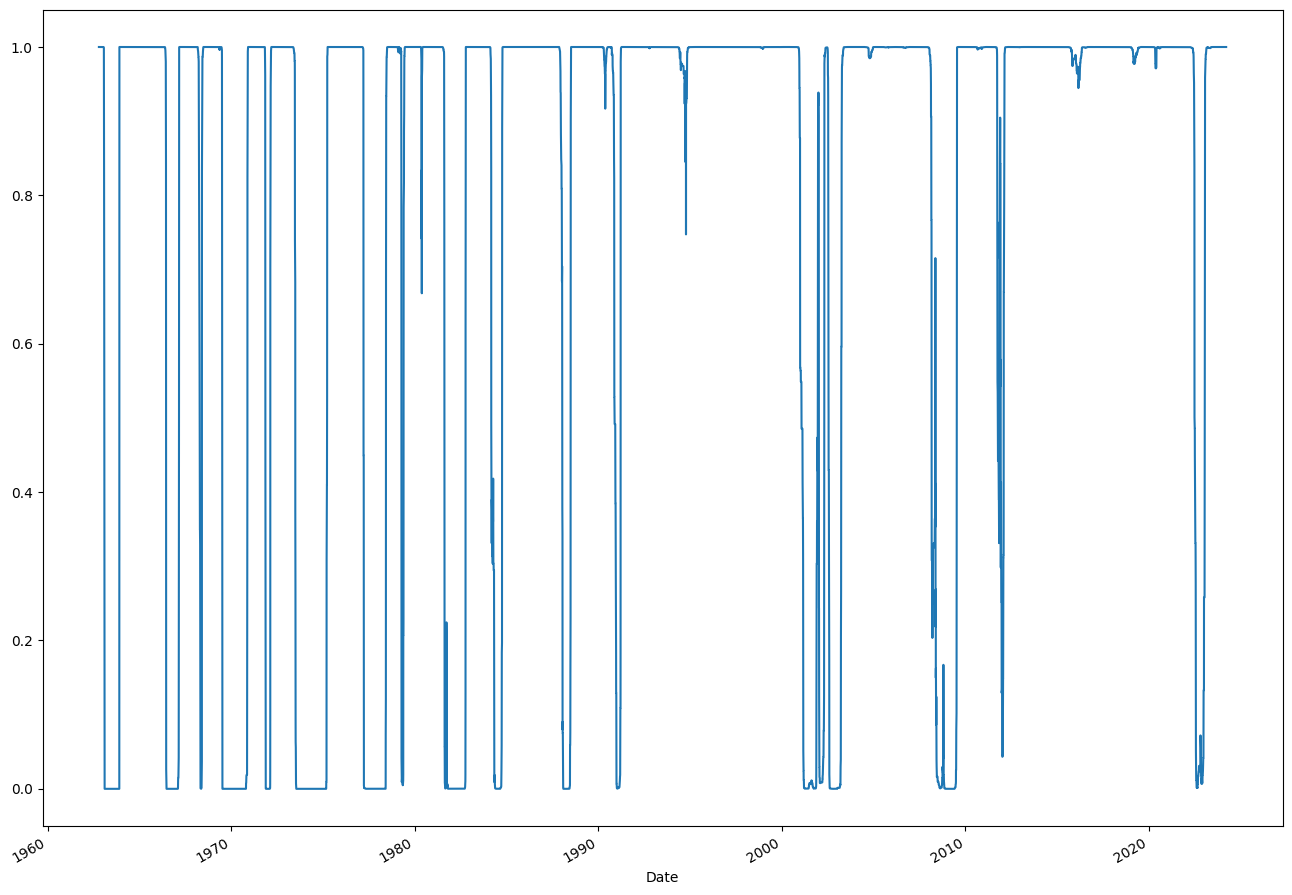

In [17]:
sizing = pd.Series(expit(model.predict(feats) + score0), index=feats.index).clip(0, 1)
sizing.plot()

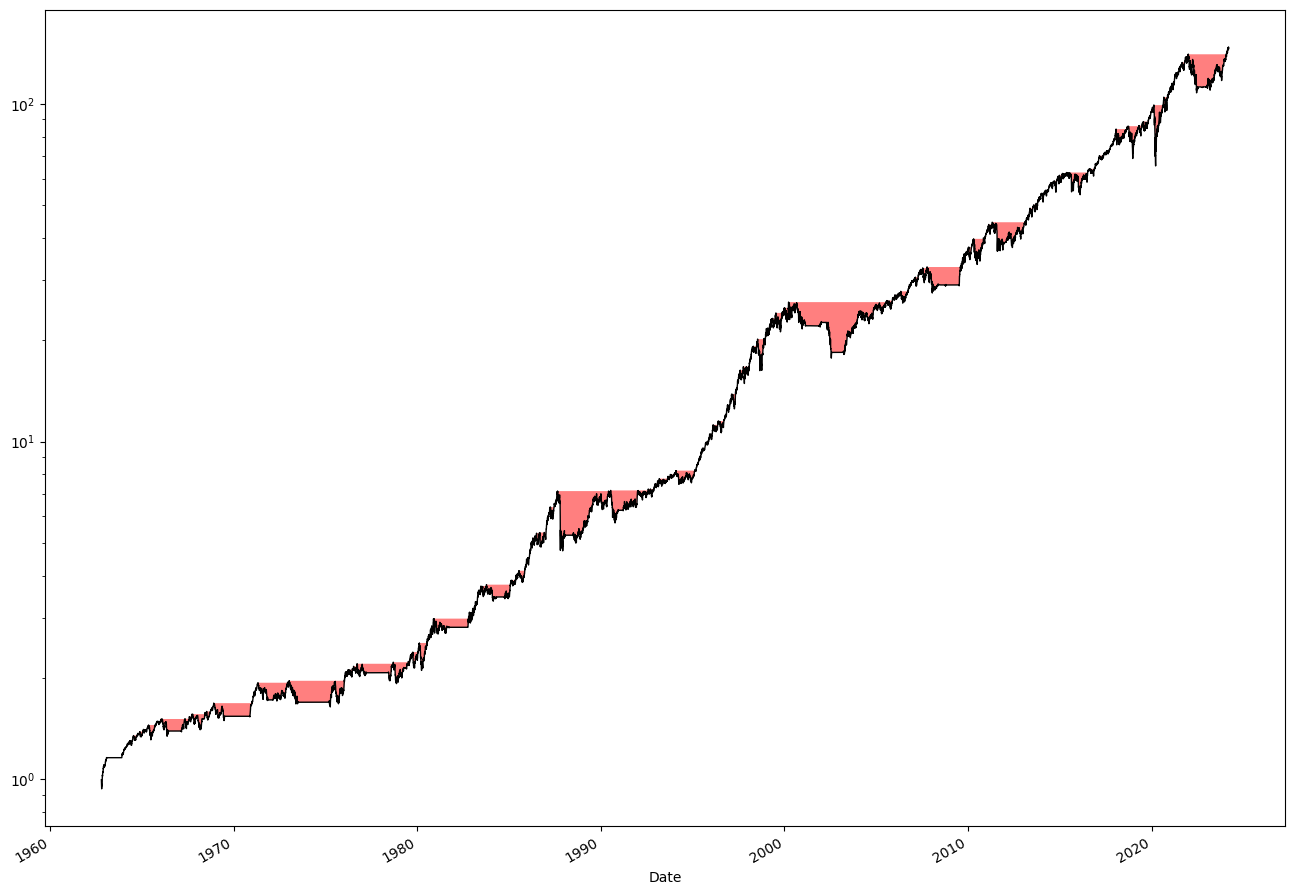

In [18]:
plot_dd(sizing * sp_rets)

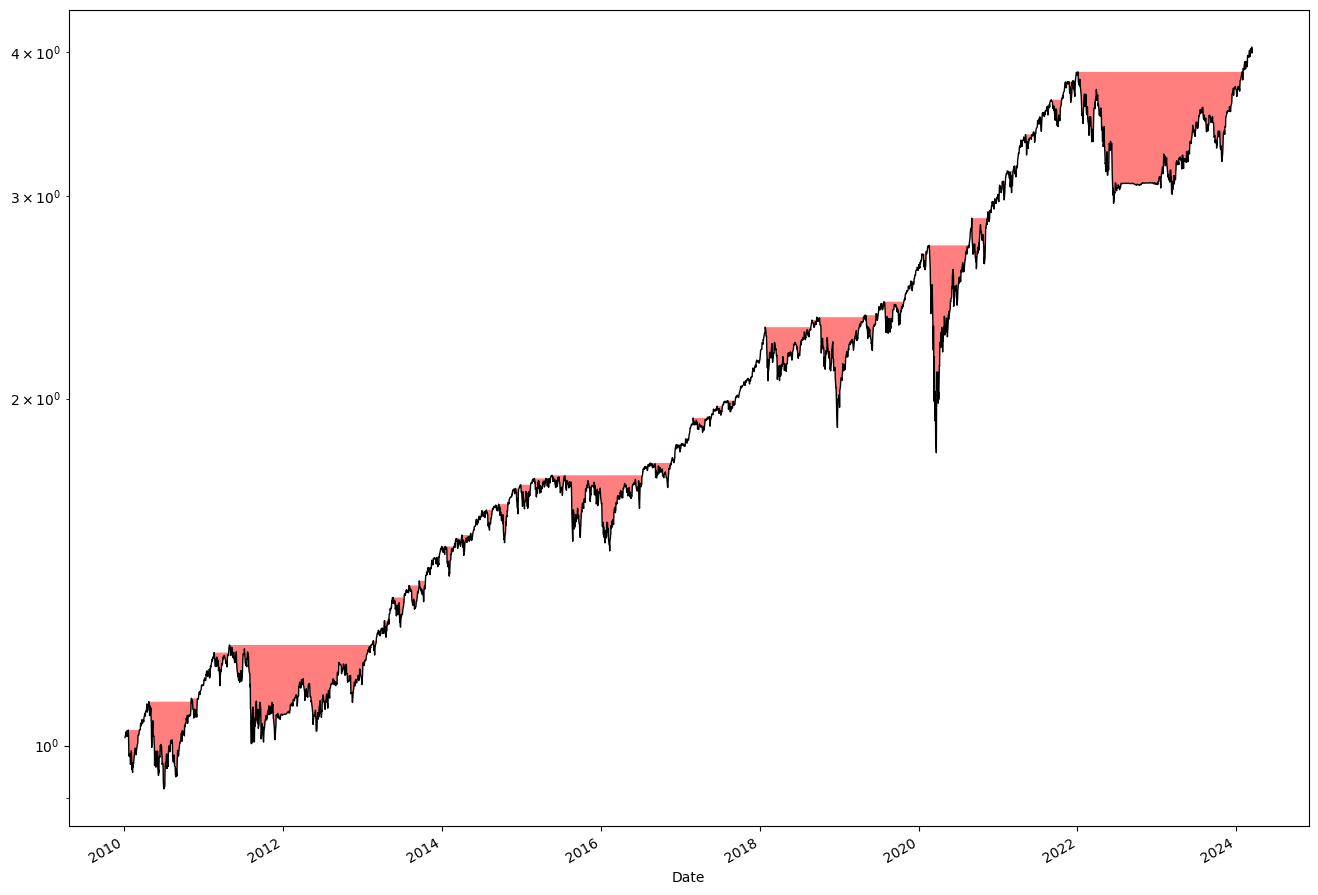

In [19]:
plot_dd((sizing * sp_rets)["2010":])

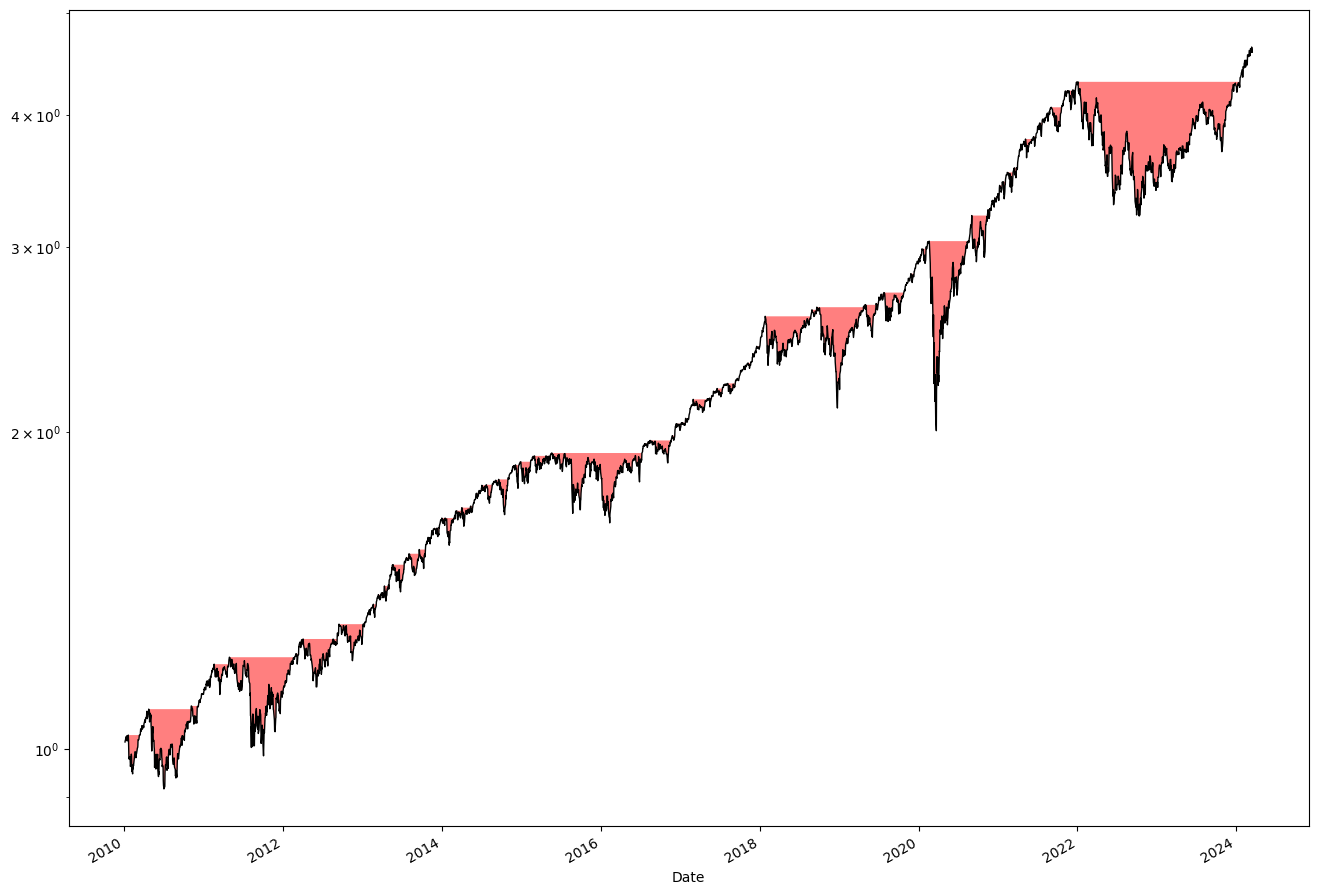

In [20]:
plot_dd((sp_rets)["2010":])